In [195]:
# Preamble
try:
    %matplotlib inline
    %config InlineBackend.figure_format='retina'
except:
    pass

import numpy as np
import pickle
from astropy.table import Table
import matplotlib.pyplot as plt

plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['axes.labelsize'] = 17
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['legend.handletextpad'] = 1
plt.rcParams['legend.borderpad'] = 0.35

In [181]:
loss = Table.read('neural_networks/loss_neural_networks.fits')
loss = loss[(np.isfinite(loss['loss_training']) & np.isfinite(loss['loss_validation']))]
loss['loss_training'] /= 1e4
loss['loss_validation'] /= 1e4

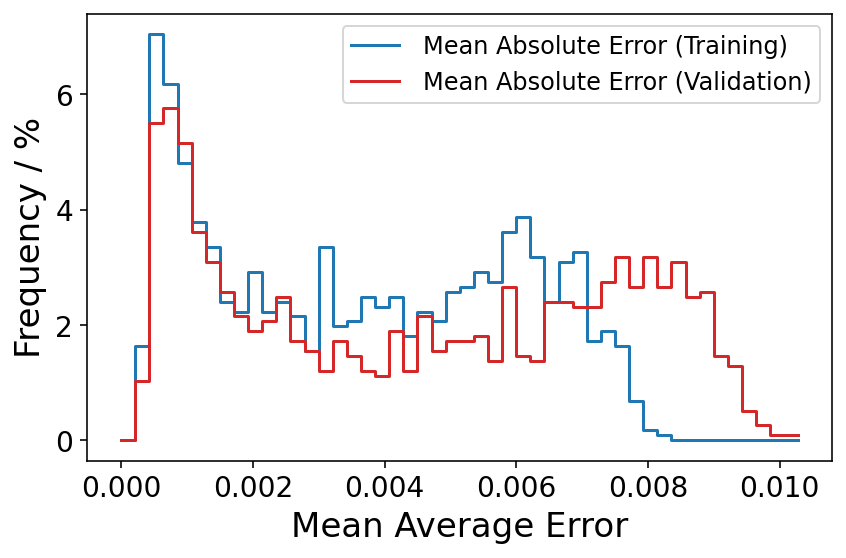

In [187]:
# Create the bins
bins = np.linspace(0, 0.0105, 50)

# Calculate histograms
hist_training, _ = np.histogram(loss['loss_training'], bins=bins)
hist_validation, _ = np.histogram(loss['loss_validation'], bins=bins)

# Normalize to sum to 1 (frequency)
hist_training = hist_training / hist_training.sum() * 100
hist_validation = hist_validation / hist_validation.sum() * 100

# Create the plot
f, ax = plt.subplots()

# Histogram plot
ax.step(bins[:-1], hist_training, where='post', c = 'C0', label='Mean Absolute Error (Training)')
ax.step(bins[:-1], hist_validation, where='post', c = 'C3', label='Mean Absolute Error (Validation)')

# Add legend
ax.legend()

# Set labels
ax.set_xlabel('Mean Average Error')
ax.set_ylabel('Frequency / %')

plt.tight_layout()
plt.savefig('loss_histogram.png',dpi=200,bbox_inches='tight')
plt.show()
plt.close()

In [188]:
unique_fe_hs = np.unique(loss['fe_h'])

In [189]:
panels = ['a)','b)','c)','d)','e)','f)','g)','h)','i)','j)','k)','l)']

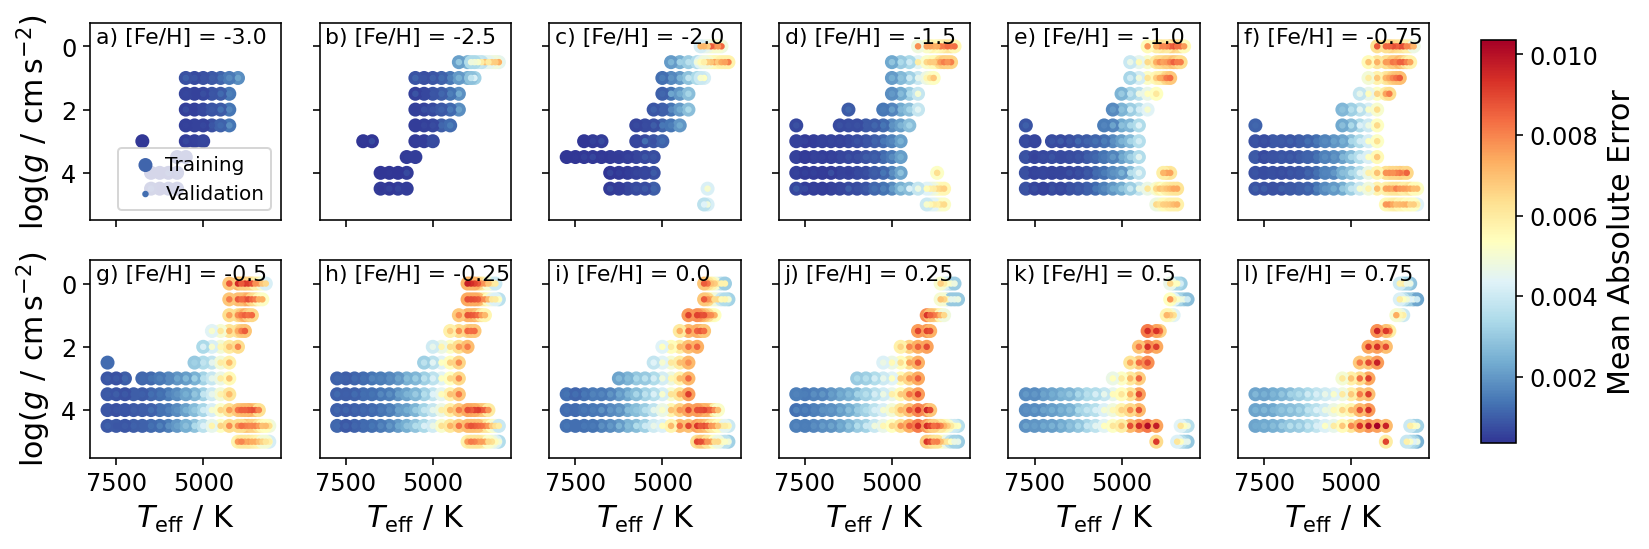

In [201]:
fig, gs = plt.subplots(2,6,figsize=(12,4),sharex=True,sharey=True)
# fig, gs = plt.subplots(6,2,figsize=(6,12),sharex=True,sharey=True)
gs = gs.flatten()

for index, unique_fe_h in enumerate(unique_fe_hs):
    ax = gs[index]
    
    ax.text(0.03,0.975,panels[index]+' [Fe/H] = '+str(unique_fe_h),va = 'top',ha='left', transform=ax.transAxes,fontsize=11)
    
    if index in [0,6]:
        ax.set_ylabel(r'$\log (g~/~\mathrm{cm\,s^{-2}})$',fontsize=15)
    if index >= 6:
        ax.set_xlabel(r'$T_\mathrm{eff}~/~\mathrm{K}$',fontsize=15)
#     if index%2==0:
#         ax.set_ylabel(r'$\log (g~/~\mathrm{cm\,s^{-2}})$',fontsize=14)
#     if index >= 10:
#         ax.set_xlabel(r'$T_\mathrm{eff}~/~\mathrm{K}$',fontsize=14)
    
    this_fe_h = loss['fe_h'] == unique_fe_h
    
    s = ax.scatter(
        loss['teff'][this_fe_h],
        loss['logg'][this_fe_h],
        c = loss['loss_training'][this_fe_h],
        vmin = np.min(loss['loss_validation']),
        vmax = np.max(loss['loss_validation']),
        label = 'Training',
        cmap = 'RdYlBu_r'
    )

    s = ax.scatter(
        loss['teff'][this_fe_h],
        loss['logg'][this_fe_h],
        c = loss['loss_validation'][this_fe_h],
        vmin = np.min(loss['loss_validation']),
        vmax = np.max(loss['loss_validation']),
        s = 5,
        label = 'Validation',
        cmap = 'RdYlBu_r'
    )

    if index == 0:
        ax.legend(handletextpad=0,fontsize=10,loc='lower right')
ax.set_xlim(8250,2750)
ax.set_ylim(5.5,-0.75)

# Position of colorbar (left, bottom, width, height)
cbar_ax = fig.add_axes([0.93, 0.15, 0.02, 0.7])  # Adjust these values for your layout
cbar = fig.colorbar(s, cax=cbar_ax)
cbar.set_label('Mean Absolute Error',fontsize=15)

plt.savefig('loss_teff_logg_feh.png',dpi=200,bbox_inches='tight')
plt.show()
plt.close()

In [ ]:
# Test Neural Networks Difference

In [ ]:
def leaky_relu(z):
    return z*(z > 0) + 0.01*z*(z < 0)

def get_spectrum_from_neural_net(scaled_labels, NN_coeffs):
    w_array_0, w_array_1, w_array_2, b_array_0, b_array_1, b_array_2, x_min, x_max = NN_coeffs
    inside = np.einsum('ij,j->i', w_array_0, scaled_labels) + b_array_0
    outside = np.einsum('ij,j->i', w_array_1, leaky_relu(inside)) + b_array_1
    spectrum = np.einsum('ij,j->i', w_array_2, leaky_relu(outside)) + b_array_2
    return spectrum

In [85]:
wavelength_file = 'training_input/galah_dr4_3dbin_wavelength_array.pickle'
wavelength_file_opener = open(wavelength_file,'rb')
wavelength_array = pickle.load(wavelength_file_opener)
wavelength_file_opener.close()

In [92]:
nn_name = '4500_4.50_0.00'

tmp = np.load('neural_networks/models/galah_dr4_neutral_network_3x3x3_'+nn_name+'_36labels.npz')
w_array_0 = tmp["w_array_0"]
w_array_1 = tmp["w_array_1"]
w_array_2 = tmp["w_array_2"]
b_array_0 = tmp["b_array_0"]
b_array_1 = tmp["b_array_1"]
b_array_2 = tmp["b_array_2"]
x_min = tmp["x_min"]
x_max = tmp["x_max"]
tmp.close()
neural_network_model = (w_array_0, w_array_1, w_array_2, b_array_0, b_array_1, b_array_2, x_min, x_max)

trainingset = Table.read('training_input/'+nn_name+'/galah_dr4_trainingset_'+nn_name+'_incl_vsini.fits')
labels = tuple(trainingset_labels.keys()[2:-1])
training_labels = np.array([trainingset[label] for label in labels]).T

training_flux_file = open('training_input/'+nn_name+'/galah_dr4_trainingset_'+nn_name+'_incl_vsini_flux_ivar.pickle','rb')
training_set_flux = pickle.load(training_flux_file)
training_flux_file.close()

model_flux = []
for index in range(np.shape(training_set_flux)[0]):
    
    model_labels = training_labels[index]
    scaled_labels = (model_labels-neural_network_model[-2])/(neural_network_model[-1]-neural_network_model[-2]) - 0.5
    model_flux.append(get_spectrum_from_neural_net(scaled_labels,neural_network_model))
model_flux = np.array(model_flux)

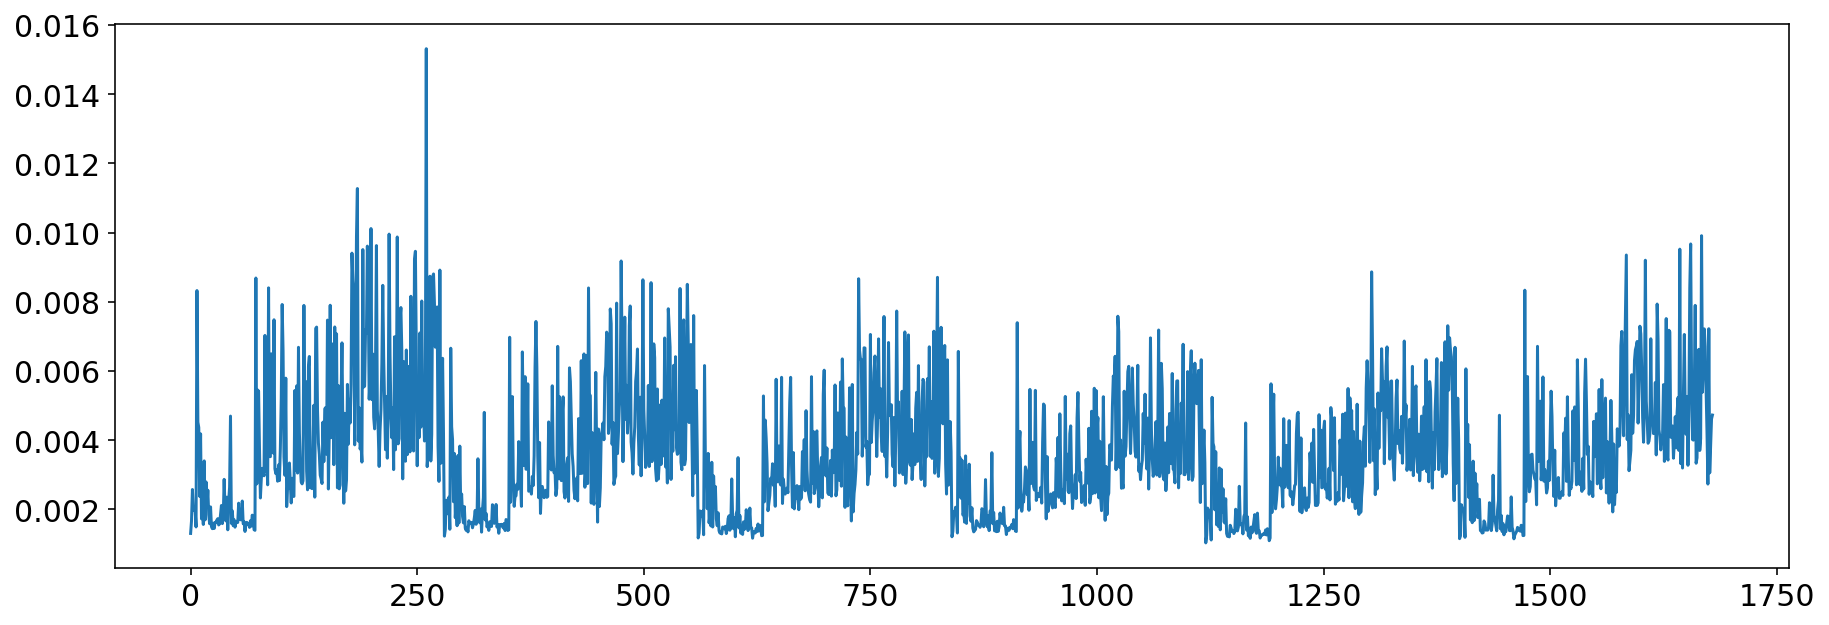

In [172]:
mae = np.median(np.abs(model_flux - training_set_flux),axis=-1)

plt.figure(figsize=(15,5))
plt.plot(mae)

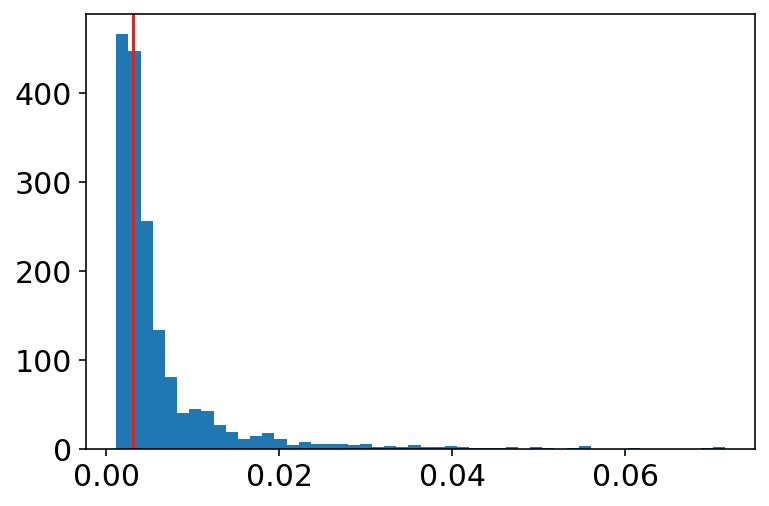

In [161]:
plt.hist(mae, bins=50)
plt.axvline(pixel_mae,c='C3')